In [1]:
from tqdm import tqdm_notebook

import numpy as np
np.random.seed(1)
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.decomposition import KernelPCA

try : 
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    vader = SentimentIntensityAnalyzer()
except : 
    import nltk
    nltk.download('vader_lexicon')  
    vader = SentimentIntensityAnalyzer()
    
import warnings
warnings.simplefilter("ignore")

/home/hfcp/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
model = pd.read_pickle('pretrained-w2v.gensim')

In [3]:
lemma_dict = model.key_to_index
vectors = model.vectors

____

In [4]:
def get_word_candidates(init, sim_const) :
    cand = []
    for w in model.similar_by_word(init) : 
        if w[1] > sim_const : 
            cand.append(w[0])
    return cand

iteratively search sentiment vocab

In [5]:
pos_container = []
cand = get_word_candidates('great', sim_const=0.75) # positiv word init
pos_container += cand
iters = 3

for proc in range(iters) :
    cand = list(set(pos_container))
    for query in cand : 
        value = get_word_candidates(query, sim_const=0.75)
        pos_container += value

neg_container = []
cand = get_word_candidates('bad', sim_const=0.75) # negative word init
neg_container += cand
iters = 3

for proc in range(iters) :
    cand = list(set(neg_container))
    for query in cand : 
        value = get_word_candidates(query, sim_const=0.75)
        neg_container += value
        
sentiment_vocab = list(set(pos_container).union(set(neg_container)))
print("===" * 10)
print("The # of positive words picked :", len(set(pos_container)))
print("The # of negative words picked :", len(set(neg_container)))
print("The # of sentimental words picked :", len(sentiment_vocab))
print("The # of intersection between pos/neg :", len(set(pos_container).intersection(set(neg_container))))
print("===" * 10)

The # of positive words picked : 282
The # of negative words picked : 384
The # of sentimental words picked : 441
The # of intersection between pos/neg : 225


In [6]:
sentiment_idx = [v for k,v in lemma_dict.items() if k in sentiment_vocab]
notsentiment_idx = [v for k,v in lemma_dict.items() if k not in sentiment_vocab]
positive_idx = [v for k,v in lemma_dict.items() if k in set(pos_container)]
negative_idx = [v for k,v in lemma_dict.items() if k in set(neg_container)]

# to easy-compare and visualize, I sampled the same number for indexes from ~sentiment candidates
# since it gives stochasticity in research, we need to do sampling multiple times for more robust result 
notsentiment_idx = np.random.choice(notsentiment_idx, len(sentiment_idx), replace=False)

___

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

In [41]:
class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AE,self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
                
    def forward(self,x):
        encoded = self.encoder(x)
        out = self.decoder(torch.relu(encoded))
        return out

In [50]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

model = AE(input_dim=vectors.shape[1], hidden_dim=30).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

batch_size = 256
epoch = 3

cuda:1


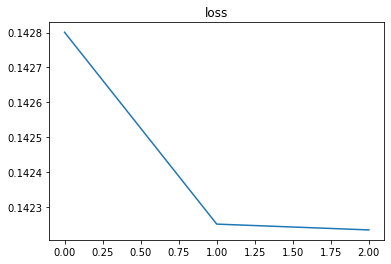

In [51]:
loss_arr =[]
for i in tqdm_notebook(range(epoch), desc='epoch') :
    # shuffling
    use_vec = vectors[np.random.choice(range(vectors.shape[0]),vectors.shape[0],False)]
    use_vec = torch.tensor(use_vec)
    
    loss_mem = []    
    for batch_idx in tqdm_notebook(range(0, use_vec.shape[0], batch_size), desc='batch') :
        x = use_vec[batch_idx:batch_idx+batch_size].to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output,x)
        loss.backward()
        optimizer.step()
        loss_mem.append(loss.item())
    loss_arr.append(np.mean(loss_mem))
    
plt.title("loss")
plt.plot(loss_arr)

In [59]:
model.eval()
%time reduced_emb = model.encoder(torch.tensor(vectors).to(device)).cpu().data.numpy()

CPU times: user 3.92 s, sys: 628 ms, total: 4.55 s
Wall time: 455 ms


____

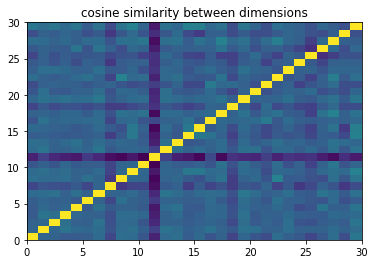

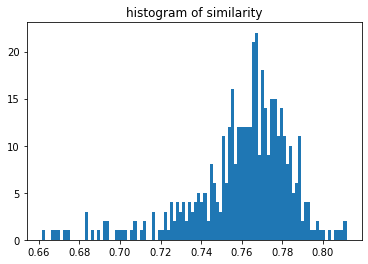

In [62]:
cossim_mat = cosine_similarity(reduced_emb.transpose(1,0))
plt.title("cosine similarity between dimensions")
plt.pcolor(cossim_mat)
plt.show()

cossim_mat[np.tril_indices_from(cossim_mat)] = np.nan
plt.title("histogram of similarity")
_ = plt.hist(cossim_mat[np.isfinite(cossim_mat)], bins=100)
plt.show()

____

In [60]:
notsentiment_vector = reduced_emb[notsentiment_idx]
sentiment_vector = reduced_emb[sentiment_idx]

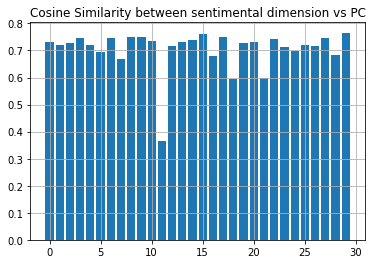

In [61]:
sim_arr = cosine_similarity(reduced_emb.transpose(1,0), vectors[:,152].reshape(1,-1)).reshape(-1)
plt.title("Cosine Similarity between sentimental dimension vs PC")
plt.bar(range(reduced_emb.shape[1]), sim_arr)
plt.grid()
plt.show()

In [63]:
def calc_ztest(dist1, dist2) : 
    mean1 = np.mean(dist1)
    mean2 = np.mean(dist2)
    std1 = np.std(dist1)
    std2 = np.std(dist2)
    return (mean1-mean2)/np.sqrt(std1**2+std2**2)

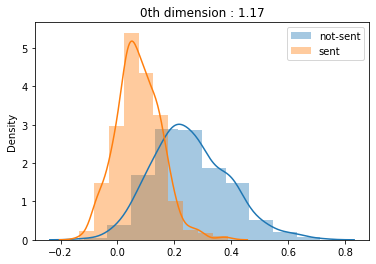

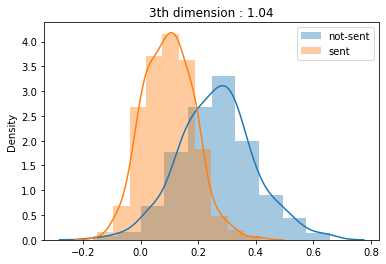

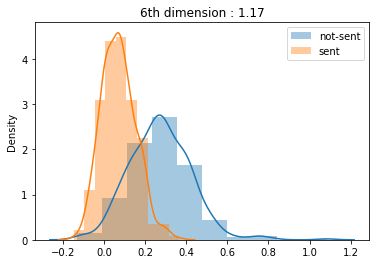

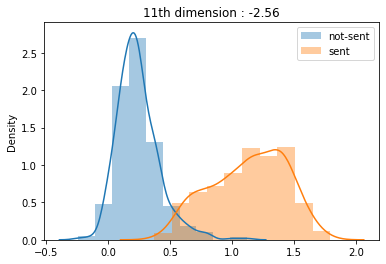

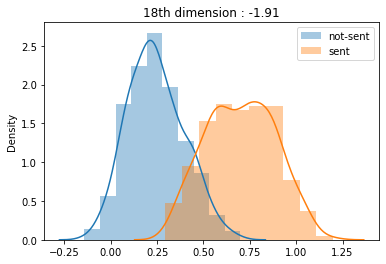

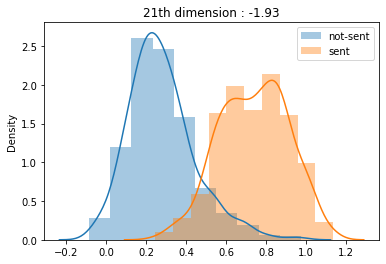

In [64]:
embed_dim = reduced_emb.shape[1]
score_mem = []

for idx in range(embed_dim) : 
    score = np.round(calc_ztest(notsentiment_vector[:,idx], sentiment_vector[:,idx]), 2)    
    if np.abs(score) >= 1 : 
        score_mem.append(idx)
        plt.title("{}th dimension : {}".format(idx, score))    
        _ = sns.distplot(notsentiment_vector[:,idx], bins=10, label='not-sent')
        _ = sns.distplot(sentiment_vector[:,idx], bins=10, label='sent')
        plt.legend()
        plt.show()

___

In [67]:
vocab_ls = list(lemma_dict.keys())
word_from_dist1 = [vocab_ls[idx] for idx, b in enumerate((reduced_emb[:,11] > 1) & (reduced_emb[:,11] < 2)) if b]
sent_from_dist1 = [vader.polarity_scores(w)['compound'] for w in word_from_dist1]
no_sentiment_corpus = [i for i in sent_from_dist1 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist1)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.0688


In [68]:
vocab_ls = list(lemma_dict.keys())
word_from_dist1 = [vocab_ls[idx] for idx, b in enumerate((reduced_emb[:,11] < .5) & (reduced_emb[:,11] > -0.5)) if b]
sent_from_dist1 = [vader.polarity_scores(w)['compound'] for w in word_from_dist1]
no_sentiment_corpus = [i for i in sent_from_dist1 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist1)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.0023


____

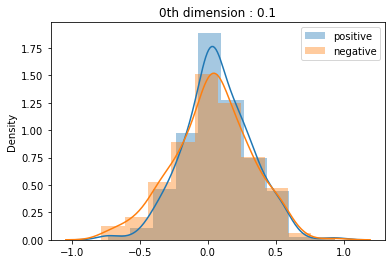

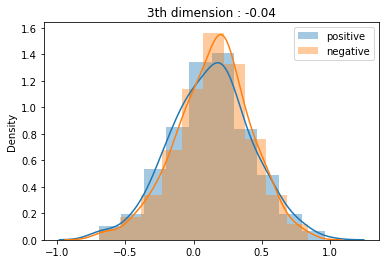

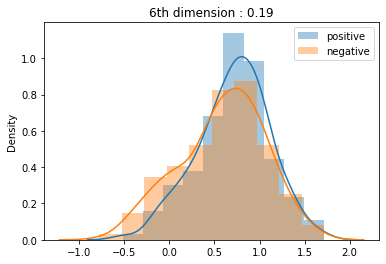

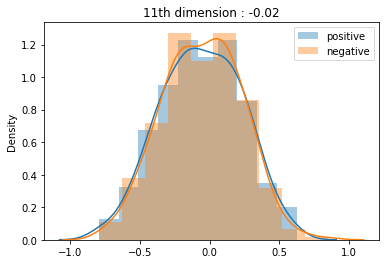

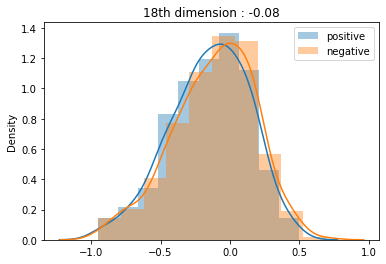

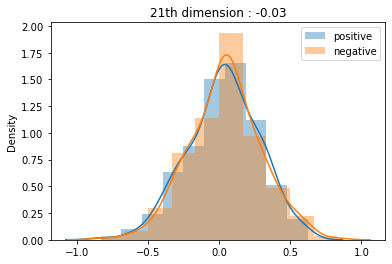

In [69]:
for idx in score_mem : 
    dist1 = vectors[positive_idx][:,idx]
    dist2 = vectors[negative_idx][:,idx]
    score = np.round(calc_ztest(dist1, dist2), 2)    
    
    plt.title("{}th dimension : {}".format(idx, score))
    _ = sns.distplot(dist1, bins=10, label='positive')
    _ = sns.distplot(dist2, bins=10, label='negative')
    plt.legend()
    plt.show()